$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 2: Optimization and Training
<a id=part2></a>

In this part we will learn how to implement optimization algorithms for deep networks. Additionally, we'll learn how to write training loops and implement a modular model trainer.
We'll use our optimizers and training code to test a few configurations for classifying images with an MLP model.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
seed = 42
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Implementing Optimization Algorithms
<a id=part2_1></a>

In the context of deep learning, an optimization algorithm is some method of iteratively updating model parameters so that the loss converges toward some local minimum (which we hope will be good enough).

Gradient descent-based methods are by far the most popular algorithms for optimization of neural network parameters.
However the high-dimensional loss-surfaces we encounter in deep learning applications are highly non-convex.
They may be riddled with local minima, saddle points, large plateaus and a host of very challenging "terrain" for gradient-based optimization.
This gave rise to many different methods of performing the parameter updates based on the loss gradients,
aiming to tackle these optimization challenges.

The most basic gradient-based update rule can be written as,

$$
\vec{\theta} \leftarrow \vec{\theta} - \eta \nabla_{\vec{\theta}} L(\vec{\theta}; \mathcal{D})
$$

where $\mathcal{D} = \left\{ (\vec{x}^i, \vec{y}^i) \right\}_{i=1}^{M}$ is our training dataset or part of it. Specifically, if we have in total $N$ training samples, then
- If $M=N$ this is known as regular gradient descent. If the dataset does not fit in memory the gradient of this loss becomes infeasible to compute.
- If $M=1$, the loss is computed w.r.t. a single different sample each time. This is known as stochastic gradient descent.
- If $1<M<N$ this is known as stochastic mini-batch gradient descent. This is the most commonly-used option.

The intuition behind gradient descent is simple: since the gradient of a multivariate function points to the direction of steepest ascent ("uphill"), we move in the opposite direction. A small step size $\eta$ known as the **learning rate** is required since the gradient can only serve as a first-order linear approximation of the function's behaviour at $\vec{\theta}$ (recall e.g. the Taylor expansion).
However in truth our loss surface generally has nontrivial curvature caused by a high order nonlinear dependency on
$\vec{\theta}$.
Thus taking a large step in the direction of the gradient is actually just as likely to increase the function value.

<img src="imgs/sgd2d.png" width="600" />

The idea behind the stochastic versions is that by constantly changing the samples we compute the loss with,
we get a dynamic error surface, i.e. it's different for each set of training samples.
This is thought to generally improve the optimization since it may help the optimizer get out of flat regions or sharp local minima since these features may disappear in the loss surface of subsequent batches. The image below illustrates this. The different lines are different 1-dimensional losses for different training set-samples.

<img src="imgs/sgd1d.png" width="600" />

Deep learning frameworks generally provide implementations of various gradient-based optimization algorithms.
Here we'll implement our own optimization module from scratch, this time keeping a similar API to the PyTorch `optim` package.

We define a base `Optimizer` class. An optimizer holds a set of parameter tensors (these are the trainable parameters of some model) and maintains internal state. It may be used as follows:
- After the forward pass has been performed the optimizer's `zero_grad()` function is invoked to clear the parameter gradients computed by previous iterations.
- After the backward pass has been performed, and gradients have been calculated for these parameters, the optimizer's `step()` function is invoked in order to update the value of each parameter based on it's gradient.

The exact method of update is implementation-specific for each optimizer and may depend on its internal state. In addition, adding the regularization penalty to the gradient is handled by the optimizer since it only depends on the parameter values (and not the data).

Here's the API of our `Optimizer`:

In [14]:
import hw2.optimizers as optimizers
help(optimizers.Optimizer)

Help on class Optimizer in module hw2.optimizers:

class Optimizer(abc.ABC)
 |  Optimizer(params)
 |  
 |  Base class for optimizers.
 |  
 |  Method resolution order:
 |      Optimizer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, params)
 |      :param params: A sequence of model parameters to optimize. Can be a
 |      list of (param,grad) tuples as returned by the Layers, or a list of
 |      pytorch tensors in which case the grad will be taken from them.
 |  
 |  step(self)
 |      Updates all the registered parameter values based on their gradients.
 |  
 |  zero_grad(self)
 |      Sets the gradient of the optimized parameters to zero (in place).
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  params
 |      :return: A sequence of parameter tuples, each tuple containing
 |      (param_data, param_grad). The data should be updated in-place
 |      accordi

## Vanilla SGD with Regularization
<a id=part2_2></a>

Let's start by implementing the simplest gradient based optimizer. The update rule will be exacly as stated above, but we'll also add a L2-regularization term to the gradient. Remember that in the **loss function**, the L2 regularization term is expressed by

$$R(\vec{\theta}) = \frac{1}{2}\lambda||\vec{\theta}||^2_2.$$

**TODO**: Complete the implementation of the `VanillaSGD` class in the `hw2/optimizers.py` module.

In [15]:
# Test VanillaSGD
torch.manual_seed(42)
p = torch.randn(500, 10)
dp = torch.randn(*p.shape)*2
params = [(p, dp)]

vsgd = optimizers.VanillaSGD(params, learn_rate=0.5, reg=0.1)
vsgd.step()

expected_p = torch.load('tests/assets/expected_vsgd.pt')
diff = torch.norm(p-expected_p).item()
print(f'diff={diff}')
test.assertLess(diff, 1e-3)

diff=0.0


## Data Generation
<a id=data></a>

In [41]:
import hw2.data as data
train = data.generate_data(1000, 10, 10)#(amount, upper_bound, length)
test = data.generate_data(100, 10, 10)

In [42]:
train_set = data.CustomDataset(train)
test_set = data.CustomDataset(test)

print(f'Train: {len(train_set)} samples')
print(f'Test: {len(test_set)} samples')

Train: 1000 samples
Test: 100 samples


In [43]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

## Training
<a id=part2_3></a>

Now that we can build a model and loss function, compute their gradients and we have an optimizer, we can finally do some training!

In the spirit of more modular software design, we'll implement a class that will aid us in automating the repetitive training loop code that we usually write over and over again. This will be useful for both training our `Layer`-based models and also later for training PyTorch `nn.Module`s.

Here's our `Trainer` API:

In [44]:
import hw2.training as training
help(training.Trainer)

Help on class Trainer in module hw2.training:

class Trainer(abc.ABC)
 |  Trainer(model: torch.nn.modules.module.Module, device: Union[torch.device, NoneType] = None)
 |  
 |  A class abstracting the various tasks of training models.
 |  
 |  Provides methods at multiple levels of granularity:
 |  - Multiple epochs (fit)
 |  - Single epoch (train_epoch/test_epoch)
 |  - Single batch (train_batch/test_batch)
 |  
 |  Method resolution order:
 |      Trainer
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model: torch.nn.modules.module.Module, device: Union[torch.device, NoneType] = None)
 |      Initialize the trainer.
 |      :param model: Instance of the model to train.
 |      :param device: torch.device to run training on (CPU or GPU).
 |  
 |  fit(self, dl_train: torch.utils.data.dataloader.DataLoader, dl_test: torch.utils.data.dataloader.DataLoader, num_epochs: int, checkpoints: str = None, early_stopping: int = None, print_every: int

The `Trainer` class splits the task of training (and evaluating) models into three conceptual levels,
- Multiple epochs - the `fit` method, which returns a `FitResult` containing losses and accuracies for all epochs.
- Single epoch - the `train_epoch` and `test_epoch` methods, which return an `EpochResult` containing losses per batch and the single accuracy result of the epoch.
- Single batch - the `train_batch` and `test_batch` methods, which return a `BatchResult` containing a single loss and the number of correctly classified samples in the batch.

It implements the first two levels. Inheriting classes are expected to implement the single-batch level methods since these are model and/or task specific.

The first thing we should do in order to verify our model, gradient calculations and optimizer implementation is to try to overfit a large model (many parameters) to a small dataset (few images). This will show us that things are working properly.

Let's begin by loading the CIFAR-10 dataset.

Now, let's implement just a small part of our training logic since that's what we need right now.

**TODO**:
1. Complete the implementation of the `train_batch()` method in the `LayerTrainer` class within the `hw2/training.py` module.
1. Update the hyperparameter values in the `part2_overfit_hp()` function in the `hw2/answers.py` module. Tweak the hyperparameter values until your model overfits a small number of samples in the code block below. You should get 100% accuracy within a few epochs.

The following code block will use your custom `Layer`-based MLP implentation, custom Vanilla SGD and custom trainer to overfit the data. The classification accuracy should be 100% within a few epochs.

In [45]:
import hw2.layers as layers
import hw2.answers as answers
from torch.utils.data import DataLoader

# Overfit to a very small dataset of 20 samples
batch_size = 10
max_batches = 2
dl_train = train_dataloader

# Get hyperparameters
hp = answers.part2_overfit_hp()

torch.manual_seed(seed)

# Build a model and loss using our custom MLP and CE implementations
model = layers.MLP(10, num_classes=10, hidden_features=[30]*2, wstd=hp['wstd'])
loss_fn = layers.CrossEntropyLoss()

# Use our custom optimizer
optimizer = optimizers.VanillaSGD(model.params(), learn_rate=hp['lr'], reg=hp['reg'])

# Run training over small dataset multiple times
trainer = training.LayerTrainer(model, loss_fn, optimizer)
best_acc = 0
for i in range(20):
    res = trainer.train_epoch(dl_train, max_batches=max_batches)
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
test.assertGreaterEqual(best_acc, 98)

train_batch:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: expected scalar type Long but found Float

Now that we know training works, let's try to fit a model to a bit more data for a few epochs, to see how well we're doing. First, we need a function to plot the FitResults object.

In [8]:
from cs236781.plot import plot_fit
plot_fit?

**TODO**:
1. Complete the implementation of the `test_batch()` method in the `LayerTrainer` class within the `hw2/training.py` module.
1. Implement the `fit()` method of the `Trainer` class within the `hw2/training.py` module.
1. Tweak the hyperparameters for this section in the `part2_optim_hp()` function in the `hw2/answers.py` module.
1. Run the following code blocks to train. Try to get above 35-40% test-set accuracy.

In [9]:
# Define a larger part of the CIFAR-10 dataset (still not the whole thing)
batch_size = 50
max_batches = 100
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size//2, shuffle=False)

In [10]:
# Define a function to train a model with our Trainer and various optimizers
def train_with_optimizer(opt_name, opt_class, fig):
    torch.manual_seed(seed)
    
    # Get hyperparameters
    hp = answers.part2_optim_hp()
    hidden_features = [128] * 5
    num_epochs = 10
    
    # Create model, loss and optimizer instances
    model = layers.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'])
    loss_fn = layers.CrossEntropyLoss()
    optimizer = opt_class(model.params(), learn_rate=hp[f'lr_{opt_name}'], reg=hp['reg'])

    # Train with the Trainer
    trainer = training.LayerTrainer(model, loss_fn, optimizer)
    fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches)
    
    fig, axes = plot_fit(fit_res, fig=fig, legend=opt_name)
    return fig

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

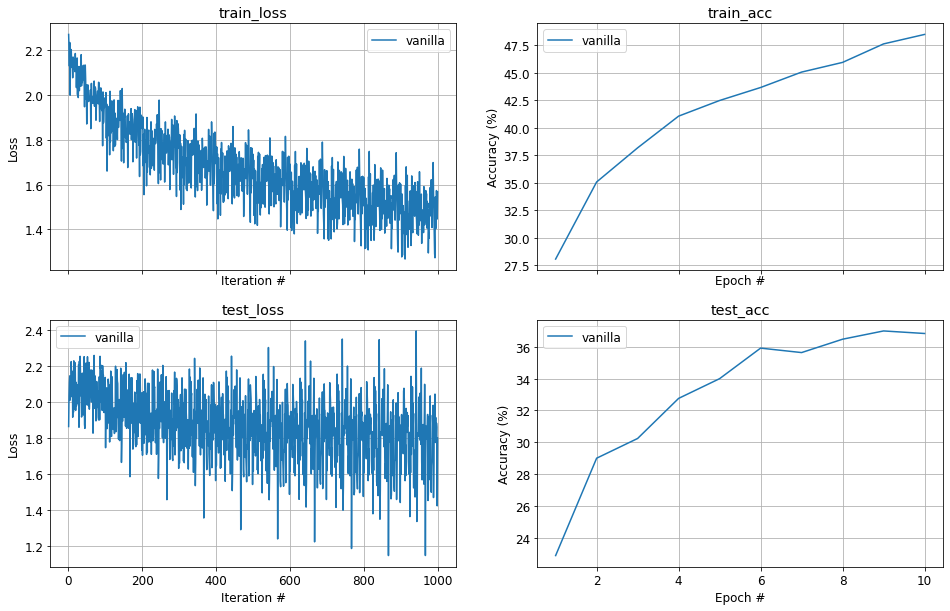

In [11]:
fig_optim = None
fig_optim = train_with_optimizer('vanilla', optimizers.VanillaSGD, fig_optim)

In [12]:
m = torch.randn(3,4)
print(m)
m.pow_(-1)

tensor([[-0.9558,  1.9075, -0.9877,  0.4197],
        [ 1.6484,  0.0551, -0.3839, -1.6656],
        [ 0.3419, -0.5408, -0.0690,  0.3107]])


tensor([[ -1.0462,   0.5243,  -1.0124,   2.3824],
        [  0.6066,  18.1475,  -2.6047,  -0.6004],
        [  2.9251,  -1.8492, -14.4872,   3.2190]])

## Momentum
<a id=part2_4></a>

The simple vanilla SGD update is rarely used in practice since it's very slow to converge relative to other optimization algorithms.

One reason is that naïvely updating in the direction of the current gradient causes it to fluctuate wildly in areas where the loss surface in some dimensions is much steeper than in others.
Another reason is that using the same learning rate for all parameters is not a great idea since not all parameters are created equal. For example, parameters associated with rare features should be updated with a larger step than ones associated with commonly-occurring features because they'll get less updates through the gradients.

Therefore more advanced optimizers take into account the previous gradients of a parameter and/or try to use a per-parameter specific learning rate instead of a common one.

Let's now implement a simple and common optimizer: SGD with Momentum. This optimizer takes **previous gradients** of a parameter into account when updating it's value instead of just the current one. In practice it usually provides faster convergence than the vanilla SGD.

The SGD with Momentum update rule can be stated as follows:
$$\begin{align}
\vec{v}_{t+1} &= \mu \vec{v}_t - \eta \delta \vec{\theta}_t \\
\vec{\theta}_{t+1} &= \vec{\theta}_t + \vec{v}_{t+1}
\end{align}$$

Where $\eta$ is the learning rate,
$\vec{\theta}$ is a model parameter,
$\delta \vec{\theta}_t=\pderiv{L}{\vec{\theta}}(\vec{\theta}_t)$ is the gradient of the loss w.r.t. to the parameter and $0\leq\mu<1$ is a hyperparameter known as momentum. 

Expanding the update rule recursively shows us now the parameter update infact depends on all previous gradient values for that parameter, where the old gradients are exponentially decayed by a factor of $\mu$ at each timestep. 

Since we're incorporating previous gradient (update directions), a noisy value of the current gradient will have less effect so that the general direction of previous updates is maintained somewhat. The following figure illustrates this.

<img src="imgs/sgd-momentum.png" width="600" />



**TODO**:
1. Complete the implementation of the `MomentumSGD` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for momentum in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following code block to compare to the vanilla SGD.

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

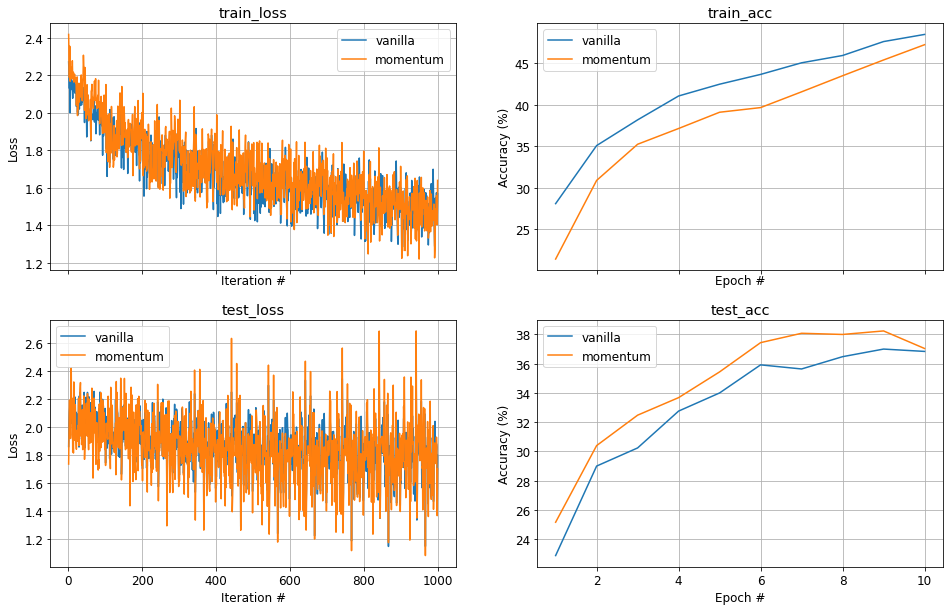

In [13]:
fig_optim = train_with_optimizer('momentum', optimizers.MomentumSGD, fig_optim)
fig_optim

## RMSProp
<a id=part2_5></a>

This is another optmizer that accounts for previous gradients, but this time it uses them to adapt the learning rate per parameter.

RMSProp maintains a decaying moving average of previous squared gradients,
$$
\vec{r}_{t+1} = \gamma\vec{r}_{t} + (1-\gamma)\delta\vec{\theta}_t^2
$$
where $0<\gamma<1$ is a decay constant usually set close to $1$, and $\delta\vec{\theta}_t^2$ denotes
element-wise squaring.

The update rule for each parameter is then,
$$
\vec{\theta}_{t+1} = \vec{\theta}_t - \left( \frac{\eta}{\sqrt{r_{t+1}+\varepsilon}} \right) \delta\vec{\theta}_t
$$

where $\varepsilon$ is a small constant to prevent numerical instability. The idea here is to decrease the learning rate for parameters with high gradient values and vice-versa. The decaying moving average prevents accumulating all the past gradients which would cause the effective learning rate to become zero.

**TODO**:
1. Complete the implementation of the `RMSProp` class in the `hw2/optimizers.py` module.
1. Tweak the learning rate for RMSProp in `part2_optim_hp()` the function in the `hw2/answers.py` module.
1. Run the following code block to compare to the other optimizers.

--- EPOCH 1/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 2/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 3/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 4/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 5/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 6/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 7/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 8/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 9/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

--- EPOCH 10/10 ---


train_batch:   0%|          | 0/100 [00:00<?, ?it/s]

test_batch:   0%|          | 0/100 [00:00<?, ?it/s]

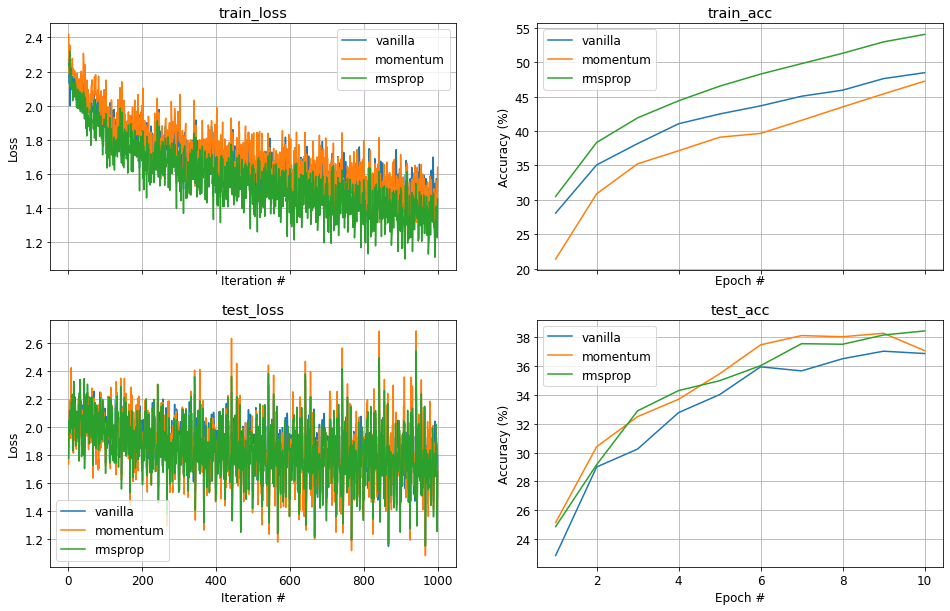

In [14]:
fig_optim = train_with_optimizer('rmsprop', optimizers.RMSProp, fig_optim)
fig_optim

Note that you should get better train/test accuracy with Momentum and RMSProp than Vanilla.

## Dropout Regularization
<a id=part2_6></a>

[Dropout](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) is a useful technique to improve generalization of deep models.

The idea is simple: during the forward pass drop, i.e. set to to zero, the activation of each neuron, with a probability of $p$. For example, if $p=0.4$ this means we **drop** the activations of 40% of the neurons (on average).

There are a few important things to note about dropout:
1. It is only performed during training. When testing our model the dropout layers should be a no-op.
1. In the backward pass, gradients are only propagated back into neurons that weren't dropped during the forward pass.
1. During testing, the activations must be scaled since the expected value of each neuron during the training phase is now $1-p$ times it's original expectation. Thus, we need to scale the test-time activations by $1-p$ to match. Equivalently, we can scale the train time activations by $1/(1-p)$.

**TODO**: 
1. Complete the implementation of the `Dropout` class in the `hw2/layers.py` module.
2. Finish the implementation of the `MLP`'s `__init__()` method in the `hw2/layers.py` module.
   If `dropout>0` you should add a `Dropout` layer after each `ReLU`.

In [15]:
from hw2.grad_compare import compare_layer_to_torch

# Check architecture of MLP with dropout layers
mlp_dropout = layers.MLP(in_features, num_classes, [50]*3, dropout=0.6)
print(mlp_dropout)
test.assertEqual(len(mlp_dropout.sequence), 10)
for b1, b2 in zip(mlp_dropout.sequence, mlp_dropout.sequence[1:]):
    if str(b1).lower() == 'relu':
        test.assertTrue(str(b2).startswith('Dropout'))
test.assertTrue(str(mlp_dropout.sequence[-1]).startswith('Linear'))

MLP, Sequential
	[0] Linear(self.in_features=3072, self.out_features=50)
	[1] ReLU
	[2] Dropout(p=0.6)
	[3] Linear(self.in_features=50, self.out_features=50)
	[4] ReLU
	[5] Dropout(p=0.6)
	[6] Linear(self.in_features=50, self.out_features=50)
	[7] ReLU
	[8] Dropout(p=0.6)
	[9] Linear(self.in_features=50, self.out_features=10)



In [16]:
# Test end-to-end gradient in train and test modes.
print('Dropout, train mode')
mlp_dropout.train(True)
for diff in compare_layer_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)

print('Dropout, test mode')
mlp_dropout.train(False)
for diff in compare_layer_to_torch(mlp_dropout, torch.randn(500, in_features)):
    test.assertLess(diff, 1e-3)

Dropout, train mode
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000
Dropout, test mode
Comparing gradients... 
input    diff=0.000
param#01 diff=0.000
param#02 diff=0.000
param#03 diff=0.000
param#04 diff=0.000
param#05 diff=0.000
param#06 diff=0.000
param#07 diff=0.000
param#08 diff=0.000


To see whether dropout really improves generalization, let's take a small training set
(small enough to overfit) and a large test set and check whether we get less overfitting and
perhaps improved test-set accuracy when using dropout.

In [17]:
# Define a small set from CIFAR-10, but take a larger test set since we want to test generalization
batch_size = 10
max_batches = 40
in_features = 3*32*32
num_classes = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size*2, shuffle=False)

**TODO**:
Tweak the hyperparameters for this section in the `part2_dropout_hp()` function in the `hw2/answers.py` module. Try to set them so that the first model (with `dropout`=0) overfits. You can disable the other dropout options until you tune the hyperparameters. We can then see the effect of dropout for generalization.

In [18]:
# Get hyperparameters
hp = answers.part2_dropout_hp()
hidden_features = [400] * 1
num_epochs = 30

*** Training with dropout= 0
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

*** Training with dropout= 0.4
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

*** Training with dropout= 0.8
--- EPOCH 1/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 7/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 13/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 19/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 25/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

--- EPOCH 30/30 ---


train_batch:   0%|          | 0/40 [00:00<?, ?it/s]

test_batch:   0%|          | 0/40 [00:00<?, ?it/s]

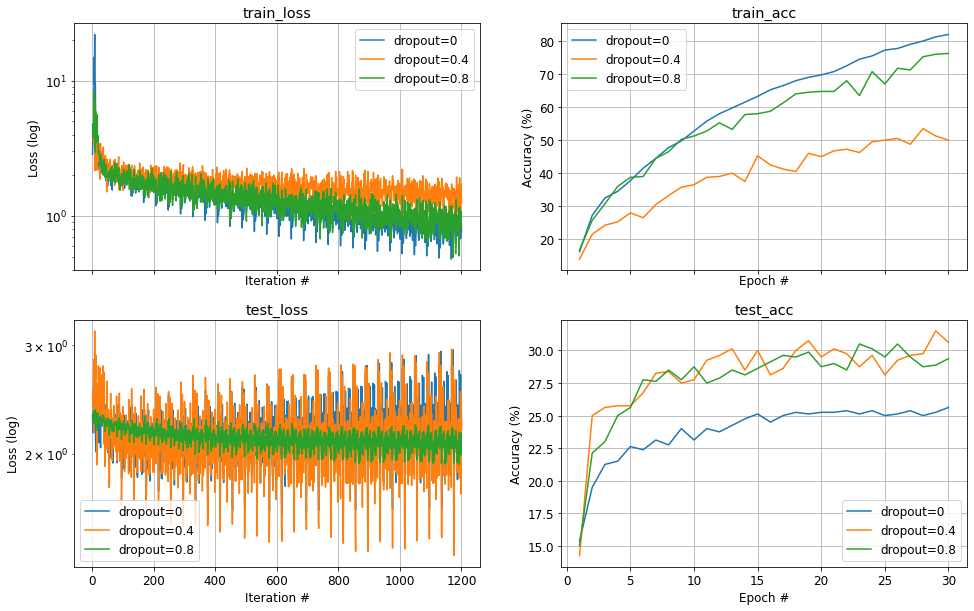

In [19]:
torch.manual_seed(seed)
fig=None
#for dropout in [0]:  # Use this for tuning the hyperparms until you overfit
for dropout in [0, 0.4, 0.8]:
    model = layers.MLP(in_features, num_classes, hidden_features, wstd=hp['wstd'], dropout=dropout)
    loss_fn = layers.CrossEntropyLoss()
    optimizer = optimizers.MomentumSGD(model.params(), learn_rate=hp['lr'], reg=0)

    print('*** Training with dropout=', dropout)
    trainer = training.LayerTrainer(model, loss_fn, optimizer)
    fit_res_dropout = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches, print_every=6)
    fig, axes = plot_fit(fit_res_dropout, fig=fig, legend=f'dropout={dropout}', log_loss=True)

## Questions
<a id=part2_7></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.

In [20]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1 

Regarding the graphs you got for the three dropout configurations:

1. Explain the graphs of no-dropout vs dropout. Do they match what you expected to see?
    - If yes, explain why and provide examples based on the graphs.
    - If no, explain what you think the problem is and what should be modified to fix it.

2. Compare the low-dropout setting to the high-dropout setting and explain based on your graphs.

In [21]:
display_answer(hw2.answers.part2_q1)

 
**Your answer:**

The graphs match what we expected to see. <br/>
In high dropout setting, 0.8, we see decreased training accuracy compared with no dropout , because training a neural network with lower dropout has a higher propensity to overfit the data.<br />

Dropout is a regularization technique, thus we expect the NN to perform better on the testing dataset when regularization is done with high probability than with lower probability. <br />
In the test accuracy section, we have that the neural network with high dropout has higher accuracy because it generalizes better. <br />



### Question 2 

When training a model with the cross-entropy loss function, is it possible for the test loss to **increase** for a few epochs while the test accuracy also **increases**?

If it's possible explain how, if it's not explain why not.

In [22]:
display_answer(hw2.answers.part2_q2)


**Your answer:**

** It is possible for both the cros entropy loss and the accuracy to simultanously increase during the testing phase.
Accuracy is the ratio of samples in the batch that are classified correcctly by taking the maximum argument in the probability vector inducd by cross entropy.
The loss is given by the equation $-y^t log(\hat{y}) $ which we have seen is equivalent to $ -x_i + log( e^{x_1} + ... +e^{x_n}) $ where i is the correct output label. 
The scenario in which the loss AND accuracy can both increase is if the entropy increases whilst the correct label retains the maximum probability.
Concretely, assume we have a mini vatch of two samples, although thhe cross entropy loss decreases in one it might increase more in the other thus the average cross entropy loss will increase, even though the classsification losss increases.

Take for example , in binary classification, in first epoch we get softmax activations : 
1. [0.1, 0.9]  , 2. [0.49 ,0.51 ] with correct labels 1. [0,1] 2. [1,0]
In second epoch we get : 
1. [ 0.4, 0.6 ] , 2. [0.51, 0.49] with correct labels 1.[0,1] 2. [1,0]

Accuracy of first mini-batch is 50% and for the second is 100%, so increased.

Loss of first mini-batch is $ [-0.9 + log(e^{0.1} + e^{0.9}) -0.49 + log( e^{0.49} + e^{0.51} ) ]/2 = 0.5371 $ 
loss of second mini-batch is $  [-0.6 + log(e^{0.4}+e^{0.6}) -0.51 + log( e^{0.49} + e^{0.51} ) ]/2 =0.64 $

Therefore both loss and accuracy increase.

Threfore for the first few epochs the classifier might get higher accuracy but the cross entropy loss  will increase, thereby yielding an increased loss. This issue in theory should be "fixed"  after a few batches when the crossentropy of what the model predicts and the true distribution decreases.
**



### Question 3 

1. Explain the difference between gradient descent and back-propagation.

2. Compare in detail between gradient descent (GD) and stochastic gradient descent (SGD).

3. Why is SGD used more often in the practice of deep learning? Provide a few justifications.

4. You would like to try GD to train your model instead of SGD, but you're concerned that your dataset won't fit in memory. A friend suggested that you should split the data into disjoint batches, do multiple forward passes until all data is exhausted, and then do one backward pass on the sum of the losses.
   1. Would this approach produce a gradient equivalent to GD? Why or why not? provide mathematical justification for your answer.
   2. You implemented the suggested approach, and were careful to use batch sizes small enough so that each batch fits in memory. However, after some number of batches you got an out of memory error. What happened?


In [23]:
display_answer(hw2.answers.part2_q3)



**Your answer:**

**a. Backpropegation is a method for training neural networks in which, using the chain rule, we are able to calculate the derivative of the loss function with respect to any of our parametrs ( weights, biases and such ).
Gradient descent is a general method of finding a local minimum of a function by taking "steps" along the direction of the gradient. From calculus we know the gradient points to the direction of steepest ascent, thereby negating the gradient goes in the direction of steepest descent. There is an implied assumption when training neural networks that if we update the parameters in the the direction of steepest descent of the value of the loss function w.r.t the parameters of the neural network we will reach a local, or as happens in practice usually, a global minimum of the loss function. 
**

**
b. Differences:

1. Computation resources : In gradient descent we calculate the gradient of the loss using the entire training dataset thus order N calculations in contrast with SGD where we sample uniformly ffrom the dataset thus have 1 calculation of the gradient of the loss function.
2. Guarantees on convergence : Using SGD we can't guarantee we are moving in the direction of steepest descent in EVERY iteration but only that the expected value over uniform distribution over the samples yields the gradient of th loss function. In gradient descent we calculate the gradient using N >> 1 samples then in this case the loss gradient closely resembles the expected value of the actual gradient of the loss function  in EVERY iteration 
3. Loss plot : Using SGD when far away from minima the convergence is more rapid than in standard gradient descent, yet when we are proximate to he minima there is a phemonema of staying at an asymptotically higher loss htan standard GD. That occurs because each update to the parameters s done according to a randomly picked sample thus the update direction never fully captures the optimal update direction close to the minima.
4. convergence rates : In SGD In k-th iteration distance between minima and k-iteration parametrs are sublinear, i.e. O(1/k), In Gradient descent the rate s linear and is O(c^k)
 ** <br \>
 **
 c. Observe computational resources in order to reach norm of less than $\epsilon >0$ in Euclidean norm, of the k-th iteration paramters and the minimzer, we need order of O(1/$\epsilon$) which is independent of N (training set size)
 when using GD the computational resources to reach same guarantee above our of order O(N log(1/$\epsilon$)) which is dependent on N. 
 
In real-world settings usually the dataset size is very large and computational resources are scarce thus SGD is more relavant.

Another factor is the quick minimization of loss of SGD in contrast with GD , even though asymptotically the loss is slightly higher using SGD than GD.
 
 ** <br \>
**d
4. A. There is a difference in the two approches.
When training using GD during backpropegation we update the weights with multilplication of dout * w^t , with dout is of dimensions (d_out, N) and w is of dimensions (d_in, N).
In the approach described we calculate the change in w, as sum of matrices that are multiplications of (d_out, batch_size) by (batch_size, d_in).
Algebraically, these are distinct operations.

<br \>

B. We have to save in the cache the inputs for each linear layers for each one of the batches. Thus we have to save the same magnitude of memory as in GD but seuquentially. Therefore we will reach a point after saving the input for each layer of each one of the batcehs that the memory requiremnt will exceed our device's ability. That is because the device cannot handle the full GD thus in the process of incrementing the memory usage increasingly until reaching the same memory requirement as GD, we will run out of memory (mathemaatically the intermidate value theorem)

** <br \> 

